In [37]:
import math
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import matplotlib as mpl
from dataclasses import dataclass
from torch.nn.grad import conv2d_weight

torch.set_default_dtype(torch.float32)

# -----------------------------
# Activations
# -----------------------------
def relu(u): return torch.relu(u)
def relu_prime(u): return (u > 0).to(u.dtype)

# -----------------------------
# Model container (4 Conv + 1 FC = 5 Layers)
# "VGG-Style": 64 -> 128 -> 256 -> 512
# -----------------------------
@dataclass
class CNN5:
    W1: torch.Tensor; b1: torch.Tensor   # (64, 3, 3, 3)
    W2: torch.Tensor; b2: torch.Tensor   # (128, 64, 3, 3)
    W3: torch.Tensor; b3: torch.Tensor   # (256, 128, 3, 3)
    W4: torch.Tensor; b4: torch.Tensor   # (512, 256, 3, 3)
    W5: torch.Tensor; b5: torch.Tensor   # (10, 512*8*8)

    @property
    def device(self): return self.W1.device

# -----------------------------
# Forward at mean states
# -----------------------------
@torch.no_grad()
def forward_u_sig(net: CNN5, x0, m1, m2, m3, m4):
    u1 = F.conv2d(x0, net.W1, net.b1, stride=1, padding=1); sig1 = relu(u1)
    u2 = F.conv2d(m1, net.W2, net.b2, stride=2, padding=1); sig2 = relu(u2)
    u3 = F.conv2d(m2, net.W3, net.b3, stride=1, padding=1); sig3 = relu(u3)
    u4 = F.conv2d(m3, net.W4, net.b4, stride=2, padding=1); sig4 = relu(u4)
    
    B = x0.shape[0]
    m4_flat = m4.reshape(B, -1) 
    u5 = m4_flat @ net.W5.t() + net.b5
    sig5 = u5

    return (u1, sig1), (u2, sig2), (u3, sig3), (u4, sig4), (u5, sig5)

class XZState:
    def __init__(self):
        self.x1 = None; self.z1 = None
        self.x2 = None; self.z2 = None
        self.x3 = None; self.z3 = None
        self.x4 = None; self.z4 = None
        self.x5 = None; self.z5 = None

# -----------------------------
# Hamiltonian x-z relaxation gradient for batch (CNN)
# -----------------------------
@torch.no_grad()
def xz_relax_batch_grad(
    net: CNN5, x0, y,
    eta=1.0, K=30,
    state: XZState | None = None,
    tol: float = 1e-4,
    warm_start: bool = True,
    beta: float = 1.0,
):
    device = net.device
    B = x0.shape[0]
    y_onehot = F.one_hot(y, num_classes=10).to(x0.dtype)

    def alloc():
        x1 = torch.zeros(B, 64, 32, 32, device=device); z1 = torch.zeros_like(x1)
        x2 = torch.zeros(B, 128, 16, 16, device=device); z2 = torch.zeros_like(x2)
        x3 = torch.zeros(B, 256, 16, 16, device=device); z3 = torch.zeros_like(x3)
        x4 = torch.zeros(B, 512, 8, 8, device=device);   z4 = torch.zeros_like(x4)
        x5 = torch.zeros(B, 10, device=device);          z5 = torch.zeros_like(x5)
        return x1,z1,x2,z2,x3,z3,x4,z4,x5,z5

    if (state is None) or (not warm_start) or (state.x1 is None) or (state.x1.shape[0] != B):
        x1,z1,x2,z2,x3,z3,x4,z4,x5,z5 = alloc()
        if state is not None:
            state.x1,state.z1,state.x2,state.z2,state.x3,state.z3,state.x4,state.z4,state.x5,state.z5 = x1,z1,x2,z2,x3,z3,x4,z4,x5,z5
    else:
        x1,z1,x2,z2,x3,z3,x4,z4,x5,z5 = state.x1,state.z1,state.x2,state.z2,state.x3,state.z3,state.x4,state.z4,state.x5,state.z5

    steps_taken = 0
    for _ in range(K):
        steps_taken += 1
        m1 = (x1 + z1) * 0.5; s1 = (x1 - z1)
        m2 = (x2 + z2) * 0.5; s2 = (x2 - z2)
        m3 = (x3 + z3) * 0.5; s3 = (x3 - z3)
        m4 = (x4 + z4) * 0.5; s4 = (x4 - z4)
        m5 = (x5 + z5) * 0.5; s5 = (x5 - z5)

        (u1, sig1), (u2, sig2), (u3, sig3), (u4, sig4), (u5, sig5) = forward_u_sig(net, x0, m1, m2, m3, m4)

        F1 = sig1 - m1; F2 = sig2 - m2
        F3 = sig3 - m3; F4 = sig4 - m4; F5 = sig5 - m5

        p = torch.softmax(m5, dim=1)
        g5 = (p - y_onehot)

        q2 = relu_prime(u2) * s2
        q3 = relu_prime(u3) * s3
        q4 = relu_prime(u4) * s4
        q5 = s5

        WTq4 = (q5 @ net.W5).reshape(B, 512, 8, 8)
        WTq3 = F.conv_transpose2d(q4, net.W4, bias=None, stride=2, padding=1, output_padding=1)
        WTq2 = F.conv_transpose2d(q3, net.W3, bias=None, stride=1, padding=1)
        WTq1 = F.conv_transpose2d(q2, net.W2, bias=None, stride=2, padding=1, output_padding=1)

        Jt1 = -s1 + WTq1; Jt2 = -s2 + WTq2
        Jt3 = -s3 + WTq3; Jt4 = -s4 + WTq4; Jt5 = -s5

        dx1 = F1 + 0.5 * Jt1; dz1 = F1 - 0.5 * Jt1
        dx2 = F2 + 0.5 * Jt2; dz2 = F2 - 0.5 * Jt2
        dx3 = F3 + 0.5 * Jt3; dz3 = F3 - 0.5 * Jt3
        dx4 = F4 + 0.5 * Jt4; dz4 = F4 - 0.5 * Jt4
        dx5 = F5 + 0.5 * Jt5 + 0.5 * beta * g5
        dz5 = F5 - 0.5 * Jt5 - 0.5 * beta * g5

        x1.add_(dx1, alpha=eta); z1.add_(dz1, alpha=eta)
        x2.add_(dx2, alpha=eta); z2.add_(dz2, alpha=eta)
        x3.add_(dx3, alpha=eta); z3.add_(dz3, alpha=eta)
        x4.add_(dx4, alpha=eta); z4.add_(dz4, alpha=eta)
        x5.add_(dx5, alpha=eta); z5.add_(dz5, alpha=eta)

        upd = (dx1.abs().mean() + dx2.abs().mean() + dx3.abs().mean() + dx4.abs().mean() + dx5.abs().mean()).item()
        if upd < tol:
            break

    if state is not None and warm_start:
        state.x1,state.z1,state.x2,state.z2,state.x3,state.z3,state.x4,state.z4,state.x5,state.z5 = x1,z1,x2,z2,x3,z3,x4,z4,x5,z5

    m1 = (x1 + z1) * 0.5; s1 = (x1 - z1)
    m2 = (x2 + z2) * 0.5; s2 = (x2 - z2)
    m3 = (x3 + z3) * 0.5; s3 = (x3 - z3)
    m4 = (x4 + z4) * 0.5; s4 = (x4 - z4)

    (u1, _), (u2, _), (u3, _), (u4, _), (_, _) = forward_u_sig(net, x0, m1, m2, m3, m4)

    delta1 = relu_prime(u1) * s1; delta2 = relu_prime(u2) * s2
    delta3 = relu_prime(u3) * s3; delta4 = relu_prime(u4) * s4; delta5 = s5

    dW1 = conv2d_weight(x0, net.W1.shape, delta1, stride=1, padding=1) / B
    dW2 = conv2d_weight(m1, net.W2.shape, delta2, stride=2, padding=1) / B
    dW3 = conv2d_weight(m2, net.W3.shape, delta3, stride=1, padding=1) / B
    dW4 = conv2d_weight(m3, net.W4.shape, delta4, stride=2, padding=1) / B
    m4_flat = m4.reshape(B, -1)
    dW5 = (delta5.t() @ m4_flat) / B

    db1 = delta1.sum(dim=(0,2,3)) / B; db2 = delta2.sum(dim=(0,2,3)) / B
    db3 = delta3.sum(dim=(0,2,3)) / B; db4 = delta4.sum(dim=(0,2,3)) / B
    db5 = delta5.mean(dim=0)

    ce = F.cross_entropy(m5, y).item()
    return (dW1,dW2,dW3,dW4,dW5), (db1,db2,db3,db4,db5), ce, steps_taken

# -----------------------------
# SGD + momentum
# -----------------------------
@torch.no_grad()
def sgd_momentum_step(net: CNN5, gradsW, gradsb, vW, vb,
                      lr=0.01, momentum=0.9, weight_decay=1e-4, clip=1.0):
    for i in range(5):
        dWi = gradsW[i] + weight_decay * getattr(net, f"W{i+1}")
        dbi = gradsb[i]
        
        gn = (dWi.norm()**2 + dbi.norm()**2)**0.5
        scale = 1.0 if gn <= clip else (clip / (gn + 1e-12))
        dWi *= scale; dbi *= scale

        vW[i].mul_(momentum).add_(dWi)
        vb[i].mul_(momentum).add_(dbi)

        getattr(net, f"W{i+1}").sub_(lr * vW[i])
        getattr(net, f"b{i+1}").sub_(lr * vb[i])

@torch.no_grad()
def ema_update(ema_net: CNN5, net: CNN5, decay=0.999):
    for i in range(1, 6):
        for param in ["W", "b"]:
            name = f"{param}{i}"
            getattr(ema_net, name).mul_(decay).add_(getattr(net, name), alpha=(1.0 - decay))

@torch.no_grad()
def accuracy(net: CNN5, loader, device, max_batches=800):
    correct = 0; total = 0
    for i, (x,y) in enumerate(loader):
        if i >= max_batches: break
        x = x.to(device); y = y.to(device)
        h1 = relu(F.conv2d(x, net.W1, net.b1, stride=1, padding=1))
        h2 = relu(F.conv2d(h1, net.W2, net.b2, stride=2, padding=1))
        h3 = relu(F.conv2d(h2, net.W3, net.b3, stride=1, padding=1))
        h4 = relu(F.conv2d(h3, net.W4, net.b4, stride=2, padding=1))
        logits = h4.reshape(x.size(0), -1) @ net.W5.t() + net.b5
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / max(1, total)

def cosine_lr(step, total_steps, lr_max=0.05, lr_min=5e-4):
    t = step / max(1, total_steps)
    return lr_min + 0.5*(lr_max - lr_min)*(1.0 + math.cos(math.pi * t))

def kaiming_init(shape, device):
    fan_in = (shape[1] * shape[2] * shape[3]) if len(shape) == 4 else shape[1]
    return math.sqrt(2.0 / fan_in) * torch.randn(shape, device=device)

# -----------------------------
# Autograd Reference
# -----------------------------
def autograd_grads_like_cnn5(net: CNN5, x, y):
    params = {}
    for i in range(1, 6):
        params[f"W{i}"] = getattr(net, f"W{i}").detach().clone().requires_grad_(True)
        params[f"b{i}"] = getattr(net, f"b{i}").detach().clone().requires_grad_(True)
    
    h1 = relu(F.conv2d(x, params['W1'], params['b1'], stride=1, padding=1))
    h2 = relu(F.conv2d(h1, params['W2'], params['b2'], stride=2, padding=1))
    h3 = relu(F.conv2d(h2, params['W3'], params['b3'], stride=1, padding=1))
    h4 = relu(F.conv2d(h3, params['W4'], params['b4'], stride=2, padding=1))
    logits = h4.reshape(x.size(0), -1) @ params['W5'].t() + params['b5']
    
    loss = F.cross_entropy(logits, y)
    loss.backward()
    
    gradsW = tuple(params[f"W{i}"].grad for i in range(1, 6))
    gradsb = tuple(params[f"b{i}"].grad for i in range(1, 6))
    return gradsW, gradsb, float(loss.detach())

# -----------------------------
# Metrics
# -----------------------------
def flat_cat(tup):
    return torch.cat([t.reshape(-1) for t in tup], dim=0)

def cos_sim(a, b, eps=1e-12):
    denom = (a.norm() * b.norm()).clamp_min(eps)
    return float((a @ b) / denom)

def relative_error(a, b, eps=1e-12):
    return float((a - b).norm() / b.norm().clamp_min(eps))

# -----------------------------
# Plotting Functions
# -----------------------------
def set_style():
    mpl.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "DejaVu Serif"],
        "font.size": 14,
        "axes.labelsize": 16,
        "axes.titlesize": 18,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
        "lines.linewidth": 2.5,
        "lines.markersize": 8,
        "figure.figsize": (8, 6),
        "text.usetex": False,
    })

def plot_results_icml(results, eta_values):
    """Plots Gradient Fidelity (Relative Error)"""
    set_style()
    plt.figure()
    
    styles = {
        0.8: {'color': '#d62728', 'marker': 'o', 'linestyle': '-'},
        1.0: {'color': '#1f77b4', 'marker': 's', 'linestyle': '--'},
        1.2: {'color': '#2ca02c', 'marker': '^', 'linestyle': '-.'},
    }

    for eta in eta_values:
        if eta not in results: continue
        data = results[eta]
        cos_steps = data['cos_steps']
        rel_err = data['relerr_globalW_hist']
        
        if len(cos_steps) == 0: continue
        style = styles.get(eta, {'color': 'black', 'marker': 'x', 'linestyle': ':'})
        
        plt.plot(cos_steps, rel_err, 
                 label=fr'$\eta={eta}$', 
                 color=style['color'], 
                 marker=style['marker'], 
                 linestyle=style['linestyle'])

    plt.yscale('log')
    plt.xlabel('Training Steps')
    plt.ylabel(r'Relative Grad Error $\frac{||\nabla_{xz} - \nabla_{BP}||}{||\nabla_{BP}||}$')
    plt.title('Gradient Fidelity (5-Layer VGG-Style)')
    plt.grid(True, which="both", ls=":", alpha=0.6)
    plt.legend(frameon=True, fancybox=False, edgecolor='k')
    plt.tight_layout()
    plt.savefig('cnn5_grad_fidelity.png', dpi=300, bbox_inches='tight')
    print("Fidelity plot saved to: cnn5_grad_fidelity.png")

def plot_convergence_icml(results, eta_values):
    """Plots Average Convergence Steps per Epoch"""
    set_style()
    plt.figure()

    styles = {
        0.8: {'color': '#d62728', 'marker': 'o', 'linestyle': '-'},
        1.0: {'color': '#1f77b4', 'marker': 's', 'linestyle': '--'},
        1.2: {'color': '#2ca02c', 'marker': '^', 'linestyle': '-.'},
    }

    for eta in eta_values:
        if eta not in results: continue
        data = results[eta]
        # We stored the list of avg steps per epoch here
        avg_steps = data['avg_steps_per_epoch']
        epochs = range(1, len(avg_steps) + 1)

        style = styles.get(eta, {'color': 'black', 'marker': 'x', 'linestyle': ':'})

        plt.plot(epochs, avg_steps,
                 label=fr'$\eta={eta}$',
                 color=style['color'],
                 marker=style['marker'],
                 linestyle=style['linestyle'])

    plt.xlabel('Epochs')
    plt.ylabel('Avg. Convergence Steps ($K$)')
    plt.title('Relaxation Convergence Speed')
    plt.grid(True, which="both", ls=":", alpha=0.6)
    plt.legend(frameon=True, fancybox=False, edgecolor='k')
    plt.tight_layout()
    plt.savefig('cnn5_convergence_steps.png', dpi=300, bbox_inches='tight')
    print("Convergence plot saved to: cnn5_convergence_steps.png")

# -----------------------------
# Main
# -----------------------------
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device:", device)
    torch.backends.cudnn.benchmark = True

    cifar_mean = (0.4914, 0.4822, 0.4465)
    cifar_std  = (0.2470, 0.2435, 0.2616)
    train_tfm = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(cifar_mean, cifar_std)
    ])
    test_tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar_mean, cifar_std)
    ])
    
    train_ds = datasets.CIFAR10("./data", train=True, download=True, transform=train_tfm)
    test_ds  = datasets.CIFAR10("./data", train=False, download=True, transform=test_tfm)
    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    epochs = 20
    K = 25
    lr_max = 0.05
    lr_min = 0.0005
    
    eta_values = [1.0] # Add more here like [0.8, 1.0, 1.2] for comparison
    compare_every = 100
    
    results = {}

    for eta in eta_values:
        print(f"\n{'='*60}")
        print(f"Training CNN5 with eta = {eta}")
        print(f"{'='*60}\n")
        
        torch.manual_seed(42)
        W1 = kaiming_init((64, 3, 3, 3), device); b1 = torch.zeros(64, device=device)
        W2 = kaiming_init((128, 64, 3, 3), device); b2 = torch.zeros(128, device=device)
        W3 = kaiming_init((256, 128, 3, 3), device); b3 = torch.zeros(256, device=device)
        W4 = kaiming_init((512, 256, 3, 3), device); b4 = torch.zeros(512, device=device)
        W5 = kaiming_init((10, 512*8*8), device); b5 = torch.zeros(10, device=device)

        net = CNN5(W1,b1,W2,b2,W3,b3,W4,b4,W5,b5)
        ema_net = CNN5(W1.clone(),b1.clone(),W2.clone(),b2.clone(),W3.clone(),b3.clone(),W4.clone(),b4.clone(),W5.clone(),b5.clone())
        vW = [torch.zeros_like(getattr(net, f"W{i}")) for i in range(1,6)]
        vb = [torch.zeros_like(getattr(net, f"b{i}")) for i in range(1,6)]

        total_steps = epochs * len(train_loader)
        global_step = 0
        state = XZState()
        
        cos_globalW_hist = []
        relerr_globalW_hist = []
        cos_steps = []
        avg_steps_per_epoch = []

        for ep in range(1, epochs+1):
            running_ce = 0.0
            epoch_steps_accum = 0
            num_batches = 0
            
            for i, (x, y) in enumerate(train_loader):
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)

                lr = cosine_lr(global_step, total_steps, lr_max=lr_max, lr_min=lr_min)

                gradsW, gradsb, ce, steps_taken = xz_relax_batch_grad(
                    net, x, y, eta=eta, K=K, state=state, warm_start=True
                )
                
                # --- COMPARISON LOGIC (Preserved) ---
                if global_step % compare_every == 0:
                    gradsW_ag, _, _ = autograd_grads_like_cnn5(net, x, y)
                    gx = flat_cat(gradsW)
                    ga = flat_cat(gradsW_ag)
                    c_sim = cos_sim(gx, ga)
                    r_err = relative_error(gx, ga)
                    cos_globalW_hist.append(c_sim)
                    relerr_globalW_hist.append(r_err)
                    cos_steps.append(global_step)
                    print(f"[eta={eta} Step {global_step}] CosSim: {c_sim:.4f} | RelErr: {r_err:.4f}")

                sgd_momentum_step(net, gradsW, gradsb, vW, vb, lr=lr)
                ema_update(ema_net, net)

                global_step += 1
                running_ce += ce
                epoch_steps_accum += steps_taken
                num_batches += 1

            # End of Epoch Metrics
            test_acc = accuracy(ema_net, test_loader, device)
            train_loss_avg = running_ce / len(train_loader)
            avg_k = epoch_steps_accum / num_batches
            avg_steps_per_epoch.append(avg_k)

            print(f">>> Epoch {ep} Done | Loss: {train_loss_avg:.4f} | TEST ACC: {test_acc*100:.2f}% | Avg Steps: {avg_k:.2f}")

        results[eta] = {
            'cos_globalW_hist': cos_globalW_hist,
            'relerr_globalW_hist': relerr_globalW_hist,
            'cos_steps': cos_steps,
            'avg_steps_per_epoch': avg_steps_per_epoch
        }

    print("Training Complete. Generating Plots...")
    
    # 1. Original Fidelity Plot
    plot_results_icml(results, eta_values)
    
    # 2. New Convergence Steps Plot (Same Style)
    plot_convergence_icml(results, eta_values)
    
    final_acc = accuracy(ema_net, test_loader, device, max_batches=2000)
    print(f"Final Test Accuracy: {final_acc*100:.2f}%")

if __name__ == "__main__":
    main()

device: cuda

Training CNN5 with eta = 1.0

[eta=1.0 Step 0] CosSim: 1.0000 | RelErr: 0.0000
[eta=1.0 Step 100] CosSim: 1.0000 | RelErr: 0.0000
[eta=1.0 Step 200] CosSim: 1.0000 | RelErr: 0.0007
[eta=1.0 Step 300] CosSim: 1.0000 | RelErr: 0.0000
>>> Epoch 1 Done | Loss: 1.5839 | TEST ACC: 33.96% | Avg Steps: 11.00
[eta=1.0 Step 400] CosSim: 1.0000 | RelErr: 0.0001
[eta=1.0 Step 500] CosSim: 1.0000 | RelErr: 0.0007
[eta=1.0 Step 600] CosSim: 1.0000 | RelErr: 0.0004
[eta=1.0 Step 700] CosSim: 1.0000 | RelErr: 0.0000
>>> Epoch 2 Done | Loss: 1.1585 | TEST ACC: 51.43% | Avg Steps: 11.00
[eta=1.0 Step 800] CosSim: 1.0000 | RelErr: 0.0004
[eta=1.0 Step 900] CosSim: 1.0000 | RelErr: 0.0000
[eta=1.0 Step 1000] CosSim: 1.0000 | RelErr: 0.0000
[eta=1.0 Step 1100] CosSim: 1.0000 | RelErr: 0.0000
>>> Epoch 3 Done | Loss: 0.9951 | TEST ACC: 64.58% | Avg Steps: 11.00
[eta=1.0 Step 1200] CosSim: 1.0000 | RelErr: 0.0001
[eta=1.0 Step 1300] CosSim: 1.0000 | RelErr: 0.0003


KeyboardInterrupt: 

In [6]:
import math
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import matplotlib as mpl
from dataclasses import dataclass
from torch.nn.grad import conv2d_weight

torch.set_default_dtype(torch.float32)

# -----------------------------
# Activations (BN REMOVED to restore Fidelity)
# -----------------------------
def relu(u): return torch.relu(u)
def relu_prime(u): return (u > 0).to(u.dtype)

# -----------------------------
# Model container (8 Conv + 1 FC = 9 Layers)
# Structure: [64-64] -> [128-128] -> [256-256] -> [512-512] -> Linear
# -----------------------------
@dataclass
class CNN9:
    # Block 1: 32x32 -> 16x16
    W1: torch.Tensor; b1: torch.Tensor   # (64, 3, 3, 3)   s=1
    W2: torch.Tensor; b2: torch.Tensor   # (64, 64, 3, 3)  s=2 (pool)
    
    # Block 2: 16x16 -> 8x8
    W3: torch.Tensor; b3: torch.Tensor   # (128, 64, 3, 3) s=1
    W4: torch.Tensor; b4: torch.Tensor   # (128, 128, 3, 3) s=2 (pool)
    
    # Block 3: 8x8 -> 4x4
    W5: torch.Tensor; b5: torch.Tensor   # (256, 128, 3, 3) s=1
    W6: torch.Tensor; b6: torch.Tensor   # (256, 256, 3, 3) s=2 (pool)
    
    # Block 4: 4x4 -> 2x2
    W7: torch.Tensor; b7: torch.Tensor   # (512, 256, 3, 3) s=1
    W8: torch.Tensor; b8: torch.Tensor   # (512, 512, 3, 3) s=2 (pool)
    
    # Classifier: 2x2 -> Flat
    W9: torch.Tensor; b9: torch.Tensor   # (10, 512*2*2)

    @property
    def device(self): return self.W1.device

# -----------------------------
# Forward at mean states (Standard Conv -> ReLU)
# -----------------------------
@torch.no_grad()
def forward_u_sig(net: CNN9, x0, m):
    # m is a list of [m1, m2, ..., m8]
    u = [None] * 9
    sig = [None] * 9
    
    # Block 1
    u[0] = F.conv2d(x0, net.W1, net.b1, stride=1, padding=1);   sig[0] = relu(u[0])
    u[1] = F.conv2d(m[0], net.W2, net.b2, stride=2, padding=1); sig[1] = relu(u[1])
    
    # Block 2
    u[2] = F.conv2d(m[1], net.W3, net.b3, stride=1, padding=1); sig[2] = relu(u[2])
    u[3] = F.conv2d(m[2], net.W4, net.b4, stride=2, padding=1); sig[3] = relu(u[3])
    
    # Block 3
    u[4] = F.conv2d(m[3], net.W5, net.b5, stride=1, padding=1); sig[4] = relu(u[4])
    u[5] = F.conv2d(m[4], net.W6, net.b6, stride=2, padding=1); sig[5] = relu(u[5])
    
    # Block 4
    u[6] = F.conv2d(m[5], net.W7, net.b7, stride=1, padding=1); sig[6] = relu(u[6])
    u[7] = F.conv2d(m[6], net.W8, net.b8, stride=2, padding=1); sig[7] = relu(u[7])
    
    # FC
    B = x0.shape[0]
    m8_flat = m[7].reshape(B, -1)
    u[8] = m8_flat @ net.W9.t() + net.b9
    sig[8] = u[8] 

    return u, sig

class XZState:
    def __init__(self, B, device):
        self.dims = [
            (B, 64, 32, 32), (B, 64, 16, 16),
            (B, 128, 16, 16), (B, 128, 8, 8),
            (B, 256, 8, 8),   (B, 256, 4, 4),
            (B, 512, 4, 4),   (B, 512, 2, 2),
            (B, 10)
        ]
        self.x = [torch.zeros(d, device=device) for d in self.dims]
        self.z = [torch.zeros(d, device=device) for d in self.dims]

    def reset(self, B, device):
        if self.x[0].shape[0] != B:
            self.__init__(B, device)

# -----------------------------
# Hamiltonian x-z relaxation gradient for batch (CNN9)
# -----------------------------
@torch.no_grad()
def xz_relax_batch_grad(
    net: CNN9, x0, y,
    eta=1.0, K=25,
    state: XZState | None = None,
    tol: float = 1e-4,
    warm_start: bool = True,
    beta: float = 1.0,
):
    device = net.device
    B = x0.shape[0]
    num_layers = 9
    
    # --- CHANGE 1: Label Smoothing (Preserves Fidelity, improves Acc) ---
    eps_ls = 0.1
    y_onehot = F.one_hot(y, num_classes=10).to(x0.dtype)
    y_smooth = (1.0 - eps_ls) * y_onehot + eps_ls / 10.0

    # Initialize State
    if state is None:
        state = XZState(B, device)
    else:
        state.reset(B, device)
    
    x = state.x; z = state.z
    
    steps_taken = 0
    for _ in range(K):
        steps_taken += 1
        
        m = [(xi + zi) * 0.5 for xi, zi in zip(x, z)]
        s = [(xi - zi) for xi, zi in zip(x, z)]
        
        u, sig = forward_u_sig(net, x0, m)

        F_err = [(si - mi) for si, mi in zip(sig, m)]
        
        p = torch.softmax(m[8], dim=1)
        
        # Use smoothed labels for gradient
        g_last = (p - y_smooth)
        
        q = [None] * num_layers
        q[8] = s[8] 
        for i in range(7, -1, -1):
            q[i] = relu_prime(u[i]) * s[i]

        Jt = [None] * num_layers
        Jt[8] = -s[8] 

        # Jt for Layer 8
        WTq8 = (q[8] @ net.W9).reshape(B, 512, 2, 2)
        Jt[7] = -s[7] + WTq8
        
        # Jt for Conv Layers
        Jt[6] = -s[6] + F.conv_transpose2d(q[7], net.W8, stride=2, padding=1, output_padding=1)
        Jt[5] = -s[5] + F.conv_transpose2d(q[6], net.W7, stride=1, padding=1)
        Jt[4] = -s[4] + F.conv_transpose2d(q[5], net.W6, stride=2, padding=1, output_padding=1)
        Jt[3] = -s[3] + F.conv_transpose2d(q[4], net.W5, stride=1, padding=1)
        Jt[2] = -s[2] + F.conv_transpose2d(q[3], net.W4, stride=2, padding=1, output_padding=1)
        Jt[1] = -s[1] + F.conv_transpose2d(q[2], net.W3, stride=1, padding=1)
        Jt[0] = -s[0] + F.conv_transpose2d(q[1], net.W2, stride=2, padding=1, output_padding=1)

        total_change = 0.0
        # Layers 0 to 7
        for i in range(8):
            dx = F_err[i] + 0.5 * Jt[i]
            dz = F_err[i] - 0.5 * Jt[i]
            x[i].add_(dx, alpha=eta)
            z[i].add_(dz, alpha=eta)
            total_change += dx.abs().mean().item()
            
        # Layer 8 (Output)
        dx8 = F_err[8] + 0.5 * Jt[8] + 0.5 * beta * g_last
        dz8 = F_err[8] - 0.5 * Jt[8] - 0.5 * beta * g_last
        x[8].add_(dx8, alpha=eta)
        z[8].add_(dz8, alpha=eta)
        total_change += dx8.abs().mean().item()

        if total_change < tol:
            break

    # Compute Gradients
    m = [(xi + zi) * 0.5 for xi, zi in zip(x, z)]
    s = [(xi - zi) for xi, zi in zip(x, z)]
    u, _ = forward_u_sig(net, x0, m)
    
    delta = [None] * num_layers
    delta[8] = s[8]
    for i in range(8):
        delta[i] = relu_prime(u[i]) * s[i]

    gradsW = []
    gradsb = []

    # W1 (stride 1)
    gradsW.append(conv2d_weight(x0, net.W1.shape, delta[0], stride=1, padding=1) / B)
    gradsb.append(delta[0].sum(dim=(0,2,3)) / B)
    # W2 (stride 2)
    gradsW.append(conv2d_weight(m[0], net.W2.shape, delta[1], stride=2, padding=1) / B)
    gradsb.append(delta[1].sum(dim=(0,2,3)) / B)
    # W3 (stride 1)
    gradsW.append(conv2d_weight(m[1], net.W3.shape, delta[2], stride=1, padding=1) / B)
    gradsb.append(delta[2].sum(dim=(0,2,3)) / B)
    # W4 (stride 2)
    gradsW.append(conv2d_weight(m[2], net.W4.shape, delta[3], stride=2, padding=1) / B)
    gradsb.append(delta[3].sum(dim=(0,2,3)) / B)
    # W5 (stride 1)
    gradsW.append(conv2d_weight(m[3], net.W5.shape, delta[4], stride=1, padding=1) / B)
    gradsb.append(delta[4].sum(dim=(0,2,3)) / B)
    # W6 (stride 2)
    gradsW.append(conv2d_weight(m[4], net.W6.shape, delta[5], stride=2, padding=1) / B)
    gradsb.append(delta[5].sum(dim=(0,2,3)) / B)
    # W7 (stride 1)
    gradsW.append(conv2d_weight(m[5], net.W7.shape, delta[6], stride=1, padding=1) / B)
    gradsb.append(delta[6].sum(dim=(0,2,3)) / B)
    # W8 (stride 2)
    gradsW.append(conv2d_weight(m[6], net.W8.shape, delta[7], stride=2, padding=1) / B)
    gradsb.append(delta[7].sum(dim=(0,2,3)) / B)
    # W9 (Linear)
    m7_flat = m[7].reshape(B, -1)
    gradsW.append((delta[8].t() @ m7_flat) / B)
    gradsb.append(delta[8].mean(dim=0))

    ce = F.cross_entropy(m[8], y).item()
    return tuple(gradsW), tuple(gradsb), ce, steps_taken

# -----------------------------
# Autograd Reference (Standard CNN9, No BN to match Relaxation)
# -----------------------------
# -----------------------------
# Autograd Reference (Now matches Label Smoothing)
# -----------------------------
def autograd_grads_like_cnn9(net: CNN9, x, y):
    params = {}
    for i in range(1, 10):
        params[f"W{i}"] = getattr(net, f"W{i}").detach().clone().requires_grad_(True)
        params[f"b{i}"] = getattr(net, f"b{i}").detach().clone().requires_grad_(True)
    
    h = x
    h = relu(F.conv2d(h, params['W1'], params['b1'], stride=1, padding=1))
    h = relu(F.conv2d(h, params['W2'], params['b2'], stride=2, padding=1))
    h = relu(F.conv2d(h, params['W3'], params['b3'], stride=1, padding=1))
    h = relu(F.conv2d(h, params['W4'], params['b4'], stride=2, padding=1))
    h = relu(F.conv2d(h, params['W5'], params['b5'], stride=1, padding=1))
    h = relu(F.conv2d(h, params['W6'], params['b6'], stride=2, padding=1))
    h = relu(F.conv2d(h, params['W7'], params['b7'], stride=1, padding=1))
    h = relu(F.conv2d(h, params['W8'], params['b8'], stride=2, padding=1))
    logits = h.reshape(x.size(0), -1) @ params['W9'].t() + params['b9']
    
    # --- FIX: Match the relaxation's label smoothing (eps=0.1) ---
    loss = F.cross_entropy(logits, y, label_smoothing=0.1)
    
    loss.backward()
    
    gradsW = tuple(params[f"W{i}"].grad for i in range(1, 10))
    gradsb = tuple(params[f"b{i}"].grad for i in range(1, 10))
    return gradsW, gradsb, float(loss.detach())

# -----------------------------
# Metrics & Plotting
# -----------------------------
def flat_cat(tup):
    return torch.cat([t.reshape(-1) for t in tup], dim=0)

def cos_sim(a, b, eps=1e-12):
    denom = (a.norm() * b.norm()).clamp_min(eps)
    return float((a @ b) / denom)

def relative_error(a, b, eps=1e-12):
    return float((a - b).norm() / b.norm().clamp_min(eps))

def set_style():
    mpl.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "DejaVu Serif"],
        "font.size": 14,
        "axes.labelsize": 16,
        "axes.titlesize": 18,
        "lines.linewidth": 2.5,
        "figure.figsize": (8, 6),
    })

def plot_results_icml(results, eta_values):
    set_style()
    plt.figure()
    styles = {
        0.8: {'color': '#d62728', 'marker': 'o', 'linestyle': '-'},
        1.0: {'color': '#1f77b4', 'marker': 's', 'linestyle': '--'},
        1.2: {'color': '#2ca02c', 'marker': '^', 'linestyle': '-.'},
    }
    for eta in eta_values:
        if eta not in results: continue
        data = results[eta]
        cos_steps = data['cos_steps']
        rel_err = data['relerr_globalW_hist']
        if len(cos_steps) == 0: continue
        style = styles.get(eta, {'color': 'black', 'marker': 'x', 'linestyle': ':'})
        plt.plot(cos_steps, rel_err, label=fr'$\eta={eta}$', **style)

    plt.yscale('log')
    plt.xlabel('Training Steps')
    plt.ylabel(r'Relative Grad Error')
    plt.title('Gradient Fidelity (CNN9)')
    plt.grid(True, which="both", ls=":", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig('cnn9_grad_fidelity.png', dpi=300)
    print("Saved cnn9_grad_fidelity.png")

def plot_convergence_icml(results, eta_values):
    set_style()
    plt.figure()
    styles = {
        0.8: {'color': '#d62728', 'marker': 'o', 'linestyle': '-'},
        1.0: {'color': '#1f77b4', 'marker': 's', 'linestyle': '--'},
        1.2: {'color': '#2ca02c', 'marker': '^', 'linestyle': '-.'},
    }
    for eta in eta_values:
        if eta not in results: continue
        data = results[eta]
        avg_steps = data['avg_steps_per_epoch']
        epochs = range(1, len(avg_steps) + 1)
        style = styles.get(eta, {'color': 'black', 'marker': 'x', 'linestyle': ':'})
        plt.plot(epochs, avg_steps, label=fr'$\eta={eta}$', **style)

    plt.xlabel('Epochs')
    plt.ylabel('Avg. Convergence Steps ($K$)')
    plt.title('Relaxation Convergence Speed (CNN9)')
    plt.grid(True, which="both", ls=":", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig('cnn9_convergence_steps.png', dpi=300)
    print("Saved cnn9_convergence_steps.png")

# -----------------------------
# Helpers
# -----------------------------
@torch.no_grad()
def sgd_momentum_step(net: CNN9, gradsW, gradsb, vW, vb,
                      lr=0.01, momentum=0.9, weight_decay=5e-4, clip=1.0):
    for i in range(9):
        dWi = gradsW[i] + weight_decay * getattr(net, f"W{i+1}")
        dbi = gradsb[i]
        
        gn = (dWi.norm()**2 + dbi.norm()**2)**0.5
        scale = 1.0 if gn <= clip else (clip / (gn + 1e-12))
        dWi *= scale; dbi *= scale

        vW[i].mul_(momentum).add_(dWi)
        vb[i].mul_(momentum).add_(dbi)

        getattr(net, f"W{i+1}").sub_(lr * vW[i])
        getattr(net, f"b{i+1}").sub_(lr * vb[i])

@torch.no_grad()
def ema_update(ema_net: CNN9, net: CNN9, decay=0.999):
    for i in range(1, 10):
        for param in ["W", "b"]:
            name = f"{param}{i}"
            getattr(ema_net, name).mul_(decay).add_(getattr(net, name), alpha=(1.0 - decay))

@torch.no_grad()
def accuracy(net: CNN9, loader, device, max_batches=800):
    correct = 0; total = 0
    for i, (x,y) in enumerate(loader):
        if i >= max_batches: break
        x = x.to(device); y = y.to(device)
        h = x
        h = relu(F.conv2d(h, net.W1, net.b1, stride=1, padding=1))
        h = relu(F.conv2d(h, net.W2, net.b2, stride=2, padding=1))
        h = relu(F.conv2d(h, net.W3, net.b3, stride=1, padding=1))
        h = relu(F.conv2d(h, net.W4, net.b4, stride=2, padding=1))
        h = relu(F.conv2d(h, net.W5, net.b5, stride=1, padding=1))
        h = relu(F.conv2d(h, net.W6, net.b6, stride=2, padding=1))
        h = relu(F.conv2d(h, net.W7, net.b7, stride=1, padding=1))
        h = relu(F.conv2d(h, net.W8, net.b8, stride=2, padding=1))
        logits = h.reshape(x.size(0), -1) @ net.W9.t() + net.b9
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / max(1, total)

def kaiming_init(shape, device):
    fan_in = (shape[1] * shape[2] * shape[3]) if len(shape) == 4 else shape[1]
    return math.sqrt(2.0 / fan_in) * torch.randn(shape, device=device)

def cosine_lr(step, total_steps, lr_max=0.05, lr_min=5e-4):
    t = step / max(1, total_steps)
    return lr_min + 0.5*(lr_max - lr_min)*(1.0 + math.cos(math.pi * t))

# -----------------------------
# Data Augmentation (Cutout - KEEPING THIS)
# -----------------------------
class Cutout(object):
    def __init__(self, length):
        self.length = length

    def __call__(self, img):
        _, h, w = img.shape
        mask = torch.ones((h, w), dtype=torch.float32)
        y = torch.randint(h, (1,)).item()
        x = torch.randint(w, (1,)).item()
        y1 = max(0, y - self.length // 2)
        y2 = min(h, y + self.length // 2)
        x1 = max(0, x - self.length // 2)
        x2 = min(w, x + self.length // 2)
        img[:, y1:y2, x1:x2] = 0.0
        return img

# -----------------------------
# Main
# -----------------------------
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    torch.backends.cudnn.benchmark = True

    cifar_mean = (0.4914, 0.4822, 0.4465)
    cifar_std  = (0.2470, 0.2435, 0.2616)
    
    # --- CHANGE 2: Cutout (Safe for gradient fidelity) ---
    train_tfm = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(cifar_mean, cifar_std),
        Cutout(length=8)
    ])
    test_tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar_mean, cifar_std)
    ])
    
    train_ds = datasets.CIFAR10("./data", train=True, download=True, transform=train_tfm)
    test_ds  = datasets.CIFAR10("./data", train=False, download=True, transform=test_tfm)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    epochs = 100
    K = 30
    lr_max = 0.033 # Back to slightly safer LR without BN
    lr_min = 0.0002
    eta_values = [1.0] 
    compare_every = 100
    
    results = {}

    for eta in eta_values:
        print(f"\nTraining CNN9 (eta={eta})...")
        
        W1 = kaiming_init((64, 3, 3, 3), device);   b1 = torch.zeros(64, device=device)
        W2 = kaiming_init((64, 64, 3, 3), device);  b2 = torch.zeros(64, device=device)
        W3 = kaiming_init((128, 64, 3, 3), device);  b3 = torch.zeros(128, device=device)
        W4 = kaiming_init((128, 128, 3, 3), device); b4 = torch.zeros(128, device=device)
        W5 = kaiming_init((256, 128, 3, 3), device); b5 = torch.zeros(256, device=device)
        W6 = kaiming_init((256, 256, 3, 3), device); b6 = torch.zeros(256, device=device)
        W7 = kaiming_init((512, 256, 3, 3), device); b7 = torch.zeros(512, device=device)
        W8 = kaiming_init((512, 512, 3, 3), device); b8 = torch.zeros(512, device=device)
        W9 = kaiming_init((10, 512*2*2), device);    b9 = torch.zeros(10, device=device)

        net = CNN9(W1,b1,W2,b2,W3,b3,W4,b4,W5,b5,W6,b6,W7,b7,W8,b8,W9,b9)
        ema_net = CNN9(W1.clone(),b1.clone(),W2.clone(),b2.clone(),W3.clone(),b3.clone(),
                       W4.clone(),b4.clone(),W5.clone(),b5.clone(),W6.clone(),b6.clone(),
                       W7.clone(),b7.clone(),W8.clone(),b8.clone(),W9.clone(),b9.clone())

        vW = [torch.zeros_like(getattr(net, f"W{i}")) for i in range(1,10)]
        vb = [torch.zeros_like(getattr(net, f"b{i}")) for i in range(1,10)]

        total_steps = epochs * len(train_loader)
        global_step = 0
        state = None 
        
        cos_globalW_hist = []
        relerr_globalW_hist = []
        cos_steps = []
        avg_steps_per_epoch = []

        for ep in range(1, epochs+1):
            running_ce = 0.0
            epoch_steps_accum = 0
            num_batches = 0
            
            for i, (x, y) in enumerate(train_loader):
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                lr = cosine_lr(global_step, total_steps, lr_max=lr_max, lr_min=lr_min)

                gradsW, gradsb, ce, steps_taken = xz_relax_batch_grad(
                    net, x, y, eta=eta, K=K, state=state, warm_start=True
                )
                if state is None: state = XZState(x.shape[0], device)

                # Fidelity Check
                if global_step % compare_every == 0:
                    gradsW_ag, _, _ = autograd_grads_like_cnn9(net, x, y)
                    gx = flat_cat(gradsW)
                    ga = flat_cat(gradsW_ag)
                    c_sim = cos_sim(gx, ga)
                    r_err = relative_error(gx, ga)
                    cos_globalW_hist.append(c_sim)
                    relerr_globalW_hist.append(r_err)
                    cos_steps.append(global_step)
                    print(f"[Step {global_step}] CosSim: {c_sim:.4f} | RelErr: {r_err:.4f}")

                sgd_momentum_step(net, gradsW, gradsb, vW, vb, lr=lr)
                
                # --- CHANGE 3: EMA decay higher ---
                ema_update(ema_net, net, decay=0.9995)

                global_step += 1
                running_ce += ce
                epoch_steps_accum += steps_taken
                num_batches += 1

            test_acc = accuracy(ema_net, test_loader, device)
            train_loss = running_ce / num_batches
            avg_k = epoch_steps_accum / num_batches
            avg_steps_per_epoch.append(avg_k)
            print(f">>> Ep {ep}: Loss {train_loss:.4f} | ACC {test_acc*100:.2f}% | Avg K: {avg_k:.1f}")

        results[eta] = {
            'cos_globalW_hist': cos_globalW_hist,
            'relerr_globalW_hist': relerr_globalW_hist,
            'cos_steps': cos_steps,
            'avg_steps_per_epoch': avg_steps_per_epoch
        }

    print("Generating Plots...")
    plot_results_icml(results, eta_values)
    plot_convergence_icml(results, eta_values)
    
    final_acc = accuracy(ema_net, test_loader, device, max_batches=2000)
    print(f"\nFinal Test Accuracy: {final_acc*100:.2f}%")

if __name__ == "__main__":
    main()

Using device: cuda



Training CNN9 (eta=1.0)...
[Step 0] CosSim: 1.0000 | RelErr: 0.0006
[Step 100] CosSim: 1.0000 | RelErr: 0.0029
[Step 200] CosSim: 1.0000 | RelErr: 0.0049
[Step 300] CosSim: 1.0000 | RelErr: 0.0022
[Step 400] CosSim: 1.0000 | RelErr: 0.0009
[Step 500] CosSim: 1.0000 | RelErr: 0.0040
[Step 600] CosSim: 1.0000 | RelErr: 0.0028
[Step 700] CosSim: 1.0000 | RelErr: 0.0011
>>> Ep 1: Loss 1.7033 | ACC 32.57% | Avg K: 19.0
[Step 800] CosSim: 1.0000 | RelErr: 0.0001
[Step 900] CosSim: 1.0000 | RelErr: 0.0021
[Step 1000] CosSim: 1.0000 | RelErr: 0.0002
[Step 1100] CosSim: 1.0000 | RelErr: 0.0006
[Step 1200] CosSim: 1.0000 | RelErr: 0.0046
[Step 1300] CosSim: 1.0000 | RelErr: 0.0010
[Step 1400] CosSim: 1.0000 | RelErr: 0.0001
[Step 1500] CosSim: 1.0000 | RelErr: 0.0006
>>> Ep 2: Loss 1.3643 | ACC 47.76% | Avg K: 19.0
[Step 1600] CosSim: 1.0000 | RelErr: 0.0025
[Step 1700] CosSim: 1.0000 | RelErr: 0.0009
[Step 1800] CosSim: 1.0000 | RelErr: 0.0010
[Step 1900] CosSim: 1.0000 | RelErr: 0.0004
[Step 

KeyboardInterrupt: 

In [16]:
import math
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import matplotlib as mpl
from dataclasses import dataclass
from torch.nn.grad import conv2d_weight
import os

torch.set_default_dtype(torch.float32)

# -----------------------------
# Activations
# -----------------------------
def relu(u): return torch.relu(u)
def relu_prime(u): return (u > 0).to(u.dtype)

# -----------------------------
# Model container (CNN9)
# -----------------------------
@dataclass
class CNN9:
    # Block 1: 32x32 -> 16x16
    W1: torch.Tensor; b1: torch.Tensor   # (64, 3, 3, 3)   s=1
    W2: torch.Tensor; b2: torch.Tensor   # (64, 64, 3, 3)  s=2 (pool)
    
    # Block 2: 16x16 -> 8x8
    W3: torch.Tensor; b3: torch.Tensor   # (128, 64, 3, 3) s=1
    W4: torch.Tensor; b4: torch.Tensor   # (128, 128, 3, 3) s=2 (pool)
    
    # Block 3: 8x8 -> 4x4
    W5: torch.Tensor; b5: torch.Tensor   # (256, 128, 3, 3) s=1
    W6: torch.Tensor; b6: torch.Tensor   # (256, 256, 3, 3) s=2 (pool)
    
    # Block 4: 4x4 -> 2x2
    W7: torch.Tensor; b7: torch.Tensor   # (512, 256, 3, 3) s=1
    W8: torch.Tensor; b8: torch.Tensor   # (512, 512, 3, 3) s=2 (pool)
    
    # Classifier: 2x2 -> Flat
    W9: torch.Tensor; b9: torch.Tensor   # (10, 512*2*2)

    @property
    def device(self): return self.W1.device

# -----------------------------
# Forward at mean states
# -----------------------------
@torch.no_grad()
def forward_u_sig(net: CNN9, x0, m):
    u = [None] * 9
    sig = [None] * 9
    
    # Block 1
    u[0] = F.conv2d(x0, net.W1, net.b1, stride=1, padding=1);   sig[0] = relu(u[0])
    u[1] = F.conv2d(m[0], net.W2, net.b2, stride=2, padding=1); sig[1] = relu(u[1])
    
    # Block 2
    u[2] = F.conv2d(m[1], net.W3, net.b3, stride=1, padding=1); sig[2] = relu(u[2])
    u[3] = F.conv2d(m[2], net.W4, net.b4, stride=2, padding=1); sig[3] = relu(u[3])
    
    # Block 3
    u[4] = F.conv2d(m[3], net.W5, net.b5, stride=1, padding=1); sig[4] = relu(u[4])
    u[5] = F.conv2d(m[4], net.W6, net.b6, stride=2, padding=1); sig[5] = relu(u[5])
    
    # Block 4
    u[6] = F.conv2d(m[5], net.W7, net.b7, stride=1, padding=1); sig[6] = relu(u[6])
    u[7] = F.conv2d(m[6], net.W8, net.b8, stride=2, padding=1); sig[7] = relu(u[7])
    
    # FC
    B = x0.shape[0]
    m8_flat = m[7].reshape(B, -1)
    u[8] = m8_flat @ net.W9.t() + net.b9
    sig[8] = u[8] 

    return u, sig

class XZState:
    def __init__(self, B, device):
        self.dims = [
            (B, 64, 32, 32), (B, 64, 16, 16),
            (B, 128, 16, 16), (B, 128, 8, 8),
            (B, 256, 8, 8),   (B, 256, 4, 4),
            (B, 512, 4, 4),   (B, 512, 2, 2),
            (B, 10)
        ]
        self.x = [torch.zeros(d, device=device) for d in self.dims]
        self.z = [torch.zeros(d, device=device) for d in self.dims]

    def reset(self, B, device):
        if self.x[0].shape[0] != B:
            self.__init__(B, device)

# -----------------------------
# Relaxation Gradient
# -----------------------------
@torch.no_grad()
def xz_relax_batch_grad(
    net: CNN9, x0, y,
    eta=1.0, K=25,
    state: XZState | None = None,
    tol: float = 1e-4,
    warm_start: bool = True,
    beta: float = 1.0,
):
    device = net.device
    B = x0.shape[0]
    num_layers = 9
    
    # Label Smoothing
    eps_ls = 0.1
    y_onehot = F.one_hot(y, num_classes=10).to(x0.dtype)
    y_smooth = (1.0 - eps_ls) * y_onehot + eps_ls / 10.0

    if state is None:
        state = XZState(B, device)
    else:
        state.reset(B, device)
    
    x = state.x; z = state.z
    
    steps_taken = 0
    for _ in range(K):
        steps_taken += 1
        
        m = [(xi + zi) * 0.5 for xi, zi in zip(x, z)]
        s = [(xi - zi) for xi, zi in zip(x, z)]
        
        u, sig = forward_u_sig(net, x0, m)
        F_err = [(si - mi) for si, mi in zip(sig, m)]
        
        p = torch.softmax(m[8], dim=1)
        g_last = (p - y_smooth)
        
        q = [None] * num_layers
        q[8] = s[8] 
        for i in range(7, -1, -1):
            q[i] = relu_prime(u[i]) * s[i]

        Jt = [None] * num_layers
        Jt[8] = -s[8] 
        WTq8 = (q[8] @ net.W9).reshape(B, 512, 2, 2)
        Jt[7] = -s[7] + WTq8
        Jt[6] = -s[6] + F.conv_transpose2d(q[7], net.W8, stride=2, padding=1, output_padding=1)
        Jt[5] = -s[5] + F.conv_transpose2d(q[6], net.W7, stride=1, padding=1)
        Jt[4] = -s[4] + F.conv_transpose2d(q[5], net.W6, stride=2, padding=1, output_padding=1)
        Jt[3] = -s[3] + F.conv_transpose2d(q[4], net.W5, stride=1, padding=1)
        Jt[2] = -s[2] + F.conv_transpose2d(q[3], net.W4, stride=2, padding=1, output_padding=1)
        Jt[1] = -s[1] + F.conv_transpose2d(q[2], net.W3, stride=1, padding=1)
        Jt[0] = -s[0] + F.conv_transpose2d(q[1], net.W2, stride=2, padding=1, output_padding=1)

        total_change = 0.0
        # Hidden Layers
        for i in range(8):
            dx = F_err[i] + 0.5 * Jt[i]
            dz = F_err[i] - 0.5 * Jt[i]
            x[i].add_(dx, alpha=eta)
            z[i].add_(dz, alpha=eta)
            total_change += dx.abs().mean().item()
            
        # Output Layer
        dx8 = F_err[8] + 0.5 * Jt[8] + 0.5 * beta * g_last
        dz8 = F_err[8] - 0.5 * Jt[8] - 0.5 * beta * g_last
        x[8].add_(dx8, alpha=eta)
        z[8].add_(dz8, alpha=eta)
        total_change += dx8.abs().mean().item()

        if total_change < tol:
            break

    # Compute Gradients
    m = [(xi + zi) * 0.5 for xi, zi in zip(x, z)]
    s = [(xi - zi) for xi, zi in zip(x, z)]
    u, _ = forward_u_sig(net, x0, m)
    
    delta = [None] * num_layers
    delta[8] = s[8]
    for i in range(8):
        delta[i] = relu_prime(u[i]) * s[i]

    gradsW = []
    gradsb = []

    # Manual conv gradients to match architecture
    gradsW.append(conv2d_weight(x0, net.W1.shape, delta[0], stride=1, padding=1) / B)
    gradsb.append(delta[0].sum(dim=(0,2,3)) / B)
    
    gradsW.append(conv2d_weight(m[0], net.W2.shape, delta[1], stride=2, padding=1) / B)
    gradsb.append(delta[1].sum(dim=(0,2,3)) / B)
    
    gradsW.append(conv2d_weight(m[1], net.W3.shape, delta[2], stride=1, padding=1) / B)
    gradsb.append(delta[2].sum(dim=(0,2,3)) / B)
    
    gradsW.append(conv2d_weight(m[2], net.W4.shape, delta[3], stride=2, padding=1) / B)
    gradsb.append(delta[3].sum(dim=(0,2,3)) / B)
    
    gradsW.append(conv2d_weight(m[3], net.W5.shape, delta[4], stride=1, padding=1) / B)
    gradsb.append(delta[4].sum(dim=(0,2,3)) / B)
    
    gradsW.append(conv2d_weight(m[4], net.W6.shape, delta[5], stride=2, padding=1) / B)
    gradsb.append(delta[5].sum(dim=(0,2,3)) / B)
    
    gradsW.append(conv2d_weight(m[5], net.W7.shape, delta[6], stride=1, padding=1) / B)
    gradsb.append(delta[6].sum(dim=(0,2,3)) / B)
    
    gradsW.append(conv2d_weight(m[6], net.W8.shape, delta[7], stride=2, padding=1) / B)
    gradsb.append(delta[7].sum(dim=(0,2,3)) / B)
    
    m7_flat = m[7].reshape(B, -1)
    gradsW.append((delta[8].t() @ m7_flat) / B)
    gradsb.append(delta[8].mean(dim=0))

    ce = F.cross_entropy(m[8], y).item()
    return tuple(gradsW), tuple(gradsb), ce, steps_taken

# -----------------------------
# Autograd Reference
# -----------------------------
def autograd_grads_like_cnn9(net: CNN9, x, y):
    params = {}
    for i in range(1, 10):
        params[f"W{i}"] = getattr(net, f"W{i}").detach().clone().requires_grad_(True)
        params[f"b{i}"] = getattr(net, f"b{i}").detach().clone().requires_grad_(True)
    
    h = x
    h = relu(F.conv2d(h, params['W1'], params['b1'], stride=1, padding=1))
    h = relu(F.conv2d(h, params['W2'], params['b2'], stride=2, padding=1))
    h = relu(F.conv2d(h, params['W3'], params['b3'], stride=1, padding=1))
    h = relu(F.conv2d(h, params['W4'], params['b4'], stride=2, padding=1))
    h = relu(F.conv2d(h, params['W5'], params['b5'], stride=1, padding=1))
    h = relu(F.conv2d(h, params['W6'], params['b6'], stride=2, padding=1))
    h = relu(F.conv2d(h, params['W7'], params['b7'], stride=1, padding=1))
    h = relu(F.conv2d(h, params['W8'], params['b8'], stride=2, padding=1))
    logits = h.reshape(x.size(0), -1) @ params['W9'].t() + params['b9']
    
    loss = F.cross_entropy(logits, y, label_smoothing=0.1)
    loss.backward()
    
    gradsW = tuple(params[f"W{i}"].grad for i in range(1, 10))
    gradsb = tuple(params[f"b{i}"].grad for i in range(1, 10))
    return gradsW, gradsb, float(loss.detach())

# -----------------------------
# Metrics & Plotting
# -----------------------------
def flat_cat(tup):
    return torch.cat([t.reshape(-1) for t in tup], dim=0)

def cos_sim(a, b, eps=1e-12):
    denom = (a.norm() * b.norm()).clamp_min(eps)
    return float((a @ b) / denom)

def relative_error(a, b, eps=1e-12):
    return float((a - b).norm() / b.norm().clamp_min(eps))

def set_style():
    mpl.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "DejaVu Serif"],
        "font.size": 14,
        "axes.labelsize": 16,
        "axes.titlesize": 18,
        "lines.linewidth": 2.5,
        "figure.figsize": (8, 6),
    })

def plot_results_icml(results, eta_values):
    set_style()
    plt.figure()
    
    # Define distinct styles for the 4 requested etas
    styles = {
        0.25: {'color': '#1f77b4', 'marker': 'o', 'linestyle': '-', 'label': r'$\eta=0.25$'},  # Blue
        0.50: {'color': '#ff7f0e', 'marker': 's', 'linestyle': '--', 'label': r'$\eta=0.50$'},  # Orange
        0.75: {'color': '#2ca02c', 'marker': '^', 'linestyle': '-.', 'label': r'$\eta=0.75$'},  # Green
        1.00: {'color': '#d62728', 'marker': 'D', 'linestyle': ':', 'label': r'$\eta=1.00$'},  # Red
    }
    
    for eta in eta_values:
        if eta not in results: continue
        data = results[eta]
        cos_steps = data['cos_steps']
        rel_err = data['relerr_globalW_hist']
        if len(cos_steps) == 0: continue
        
        # Get style or default
        st = styles.get(eta, {'color': 'black', 'marker': 'x', 'linestyle': '-'})
        
        plt.plot(cos_steps, rel_err, **st)

    plt.yscale('log')
    plt.xlabel('Training Steps')
    plt.ylabel(r'Relative Grad Error')
    plt.title('Gradient Fidelity (CNN9)')
    plt.grid(True, which="both", ls=":", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig('cnn9_grad_fidelity.png', dpi=300)
    print("Saved cnn9_grad_fidelity.png")

def plot_convergence_icml(results, eta_values):
    set_style()
    plt.figure()
    
    styles = {
        0.25: {'color': '#1f77b4', 'marker': 'o', 'linestyle': '-', 'label': r'$\eta=0.25$'},
        0.50: {'color': '#ff7f0e', 'marker': 's', 'linestyle': '--', 'label': r'$\eta=0.50$'},
        0.75: {'color': '#2ca02c', 'marker': '^', 'linestyle': '-.', 'label': r'$\eta=0.75$'},
        1.00: {'color': '#d62728', 'marker': 'D', 'linestyle': ':', 'label': r'$\eta=1.00$'},
    }
    
    for eta in eta_values:
        if eta not in results: continue
        data = results[eta]
        avg_steps = data['avg_steps_per_epoch']
        epochs = range(1, len(avg_steps) + 1)
        
        st = styles.get(eta, {'color': 'black', 'marker': 'x', 'linestyle': '-'})
        
        plt.plot(epochs, avg_steps, **st)

    plt.xlabel('Epochs')
    plt.ylabel('Avg. Convergence Steps ($K$)')
    plt.title('Relaxation Convergence Speed (CNN9)')
    plt.grid(True, which="both", ls=":", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig('cnn9_convergence_steps.png', dpi=300)
    print("Saved cnn9_convergence_steps.png")

# -----------------------------
# Helpers
# -----------------------------
@torch.no_grad()
def sgd_momentum_step(net: CNN9, gradsW, gradsb, vW, vb,
                      lr=0.01, momentum=0.9, weight_decay=5e-4, clip=1.0):
    for i in range(9):
        dWi = gradsW[i] + weight_decay * getattr(net, f"W{i+1}")
        dbi = gradsb[i]
        
        gn = (dWi.norm()**2 + dbi.norm()**2)**0.5
        scale = 1.0 if gn <= clip else (clip / (gn + 1e-12))
        dWi *= scale; dbi *= scale

        vW[i].mul_(momentum).add_(dWi)
        vb[i].mul_(momentum).add_(dbi)

        getattr(net, f"W{i+1}").sub_(lr * vW[i])
        getattr(net, f"b{i+1}").sub_(lr * vb[i])

@torch.no_grad()
def ema_update(ema_net: CNN9, net: CNN9, decay=0.999):
    for i in range(1, 10):
        for param in ["W", "b"]:
            name = f"{param}{i}"
            getattr(ema_net, name).mul_(decay).add_(getattr(net, name), alpha=(1.0 - decay))

@torch.no_grad()
def accuracy(net: CNN9, loader, device, max_batches=800):
    correct = 0; total = 0
    for i, (x,y) in enumerate(loader):
        if i >= max_batches: break
        x = x.to(device); y = y.to(device)
        u, _ = forward_u_sig(net, x, [torch.zeros_like(x)] * 8) # Dummy m for forward structure, actual func handles it
        # Actually need simple forward here to match standard inference
        h = x
        h = relu(F.conv2d(h, net.W1, net.b1, stride=1, padding=1))
        h = relu(F.conv2d(h, net.W2, net.b2, stride=2, padding=1))
        h = relu(F.conv2d(h, net.W3, net.b3, stride=1, padding=1))
        h = relu(F.conv2d(h, net.W4, net.b4, stride=2, padding=1))
        h = relu(F.conv2d(h, net.W5, net.b5, stride=1, padding=1))
        h = relu(F.conv2d(h, net.W6, net.b6, stride=2, padding=1))
        h = relu(F.conv2d(h, net.W7, net.b7, stride=1, padding=1))
        h = relu(F.conv2d(h, net.W8, net.b8, stride=2, padding=1))
        logits = h.reshape(x.size(0), -1) @ net.W9.t() + net.b9
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / max(1, total)

def kaiming_init(shape, device):
    fan_in = (shape[1] * shape[2] * shape[3]) if len(shape) == 4 else shape[1]
    return math.sqrt(2.0 / fan_in) * torch.randn(shape, device=device)

def cosine_lr(step, total_steps, lr_max=0.05, lr_min=5e-4):
    t = step / max(1, total_steps)
    return lr_min + 0.5*(lr_max - lr_min)*(1.0 + math.cos(math.pi * t))

class Cutout(object):
    def __init__(self, length):
        self.length = length
    def __call__(self, img):
        _, h, w = img.shape
        mask = torch.ones((h, w), dtype=torch.float32)
        y = torch.randint(h, (1,)).item()
        x = torch.randint(w, (1,)).item()
        y1 = max(0, y - self.length // 2)
        y2 = min(h, y + self.length // 2)
        x1 = max(0, x - self.length // 2)
        x2 = min(w, x + self.length // 2)
        img[:, y1:y2, x1:x2] = 0.0
        return img

# -----------------------------
# Main
# -----------------------------
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    torch.backends.cudnn.benchmark = True

    cifar_mean = (0.4914, 0.4822, 0.4465)
    cifar_std  = (0.2470, 0.2435, 0.2616)
    
    train_tfm = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(cifar_mean, cifar_std),
        Cutout(length=8)
    ])
    test_tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar_mean, cifar_std)
    ])
    
    train_ds = datasets.CIFAR10("./data", train=True, download=True, transform=train_tfm)
    test_ds  = datasets.CIFAR10("./data", train=False, download=True, transform=test_tfm)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    epochs = 100
    
    # --- UPDATED PARAMETERS ---
    # Iterating over the requested 4 etas
    eta_values = [0.25, 0.5, 0.75, 1.0]
    
    # Increased K to 1000
    K_limit = 1000 
    
    # Higher tolerance of 1e-6
    tolerance = 1e-6
    
    lr_max = 0.035
    lr_min = 0.0002
    compare_every = 100
    
    results = {}

    for eta in eta_values:
        print(f"\n========================================")
        print(f"Training CNN9 (eta={eta}, K={K_limit}, tol={tolerance})")
        print(f"========================================")
        
        # Init Model
        W1 = kaiming_init((64, 3, 3, 3), device);   b1 = torch.zeros(64, device=device)
        W2 = kaiming_init((64, 64, 3, 3), device);  b2 = torch.zeros(64, device=device)
        W3 = kaiming_init((128, 64, 3, 3), device);  b3 = torch.zeros(128, device=device)
        W4 = kaiming_init((128, 128, 3, 3), device); b4 = torch.zeros(128, device=device)
        W5 = kaiming_init((256, 128, 3, 3), device); b5 = torch.zeros(256, device=device)
        W6 = kaiming_init((256, 256, 3, 3), device); b6 = torch.zeros(256, device=device)
        W7 = kaiming_init((512, 256, 3, 3), device); b7 = torch.zeros(512, device=device)
        W8 = kaiming_init((512, 512, 3, 3), device); b8 = torch.zeros(512, device=device)
        W9 = kaiming_init((10, 512*2*2), device);    b9 = torch.zeros(10, device=device)

        net = CNN9(W1,b1,W2,b2,W3,b3,W4,b4,W5,b5,W6,b6,W7,b7,W8,b8,W9,b9)
        ema_net = CNN9(W1.clone(),b1.clone(),W2.clone(),b2.clone(),W3.clone(),b3.clone(),
                       W4.clone(),b4.clone(),W5.clone(),b5.clone(),W6.clone(),b6.clone(),
                       W7.clone(),b7.clone(),W8.clone(),b8.clone(),W9.clone(),b9.clone())

        vW = [torch.zeros_like(getattr(net, f"W{i}")) for i in range(1,10)]
        vb = [torch.zeros_like(getattr(net, f"b{i}")) for i in range(1,10)]

        total_steps = epochs * len(train_loader)
        global_step = 0
        state = None 
        
        cos_globalW_hist = []
        relerr_globalW_hist = []
        cos_steps = []
        avg_steps_per_epoch = []

        for ep in range(1, epochs+1):
            running_ce = 0.0
            epoch_steps_accum = 0
            num_batches = 0
            
            for i, (x, y) in enumerate(train_loader):
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                lr = cosine_lr(global_step, total_steps, lr_max=lr_max, lr_min=lr_min)

                # Passing updated K and Tol here
                gradsW, gradsb, ce, steps_taken = xz_relax_batch_grad(
                    net, x, y, eta=eta, K=K_limit, state=state, tol=tolerance, warm_start=True
                )
                if state is None: state = XZState(x.shape[0], device)

                # Fidelity Check
                if global_step % compare_every == 0:
                    gradsW_ag, _, _ = autograd_grads_like_cnn9(net, x, y)
                    gx = flat_cat(gradsW)
                    ga = flat_cat(gradsW_ag)
                    c_sim = cos_sim(gx, ga)
                    r_err = relative_error(gx, ga)
                    cos_globalW_hist.append(c_sim)
                    relerr_globalW_hist.append(r_err)
                    cos_steps.append(global_step)
                    
                    # Optional: Print progress less frequently to reduce clutter
                    if global_step % (compare_every * 5) == 0:
                        print(f"[Step {global_step}] CosSim: {c_sim:.4f} | RelErr: {r_err:.4f}")

                sgd_momentum_step(net, gradsW, gradsb, vW, vb, lr=lr)
                ema_update(ema_net, net, decay=0.9995)

                global_step += 1
                running_ce += ce
                epoch_steps_accum += steps_taken
                num_batches += 1

            test_acc = accuracy(ema_net, test_loader, device)
            train_loss = running_ce / num_batches
            avg_k = epoch_steps_accum / num_batches
            avg_steps_per_epoch.append(avg_k)
            print(f">>> Ep {ep}: Loss {train_loss:.4f} | ACC {test_acc*100:.2f}% | Avg K: {avg_k:.1f}")

        results[eta] = {
            'cos_globalW_hist': cos_globalW_hist,
            'relerr_globalW_hist': relerr_globalW_hist,
            'cos_steps': cos_steps,
            'avg_steps_per_epoch': avg_steps_per_epoch
        }

    # --- SAVE DATA FOR POST PROCESSING ---
    print("\nSaving results to experiment_data.pt ...")
    torch.save(results, "experiment_data.pt")
    print("Data Saved.")

    print("Generating Plots...")
    plot_results_icml(results, eta_values)
    plot_convergence_icml(results, eta_values)
    
if __name__ == "__main__":
    main()

Using device: cuda

Training CNN9 (eta=0.25, K=1000, tol=1e-06)
[Step 0] CosSim: 1.0000 | RelErr: 0.0003
[Step 500] CosSim: 1.0000 | RelErr: 0.0003


RuntimeError: Given groups=1, weight of size [64, 64, 3, 3], expected input[256, 3, 32, 32] to have 64 channels, but got 3 channels instead

Loading experiment_data_seed11_18convergence.pt...

--- Generating Plots ---
Plotting Norm Ratio...


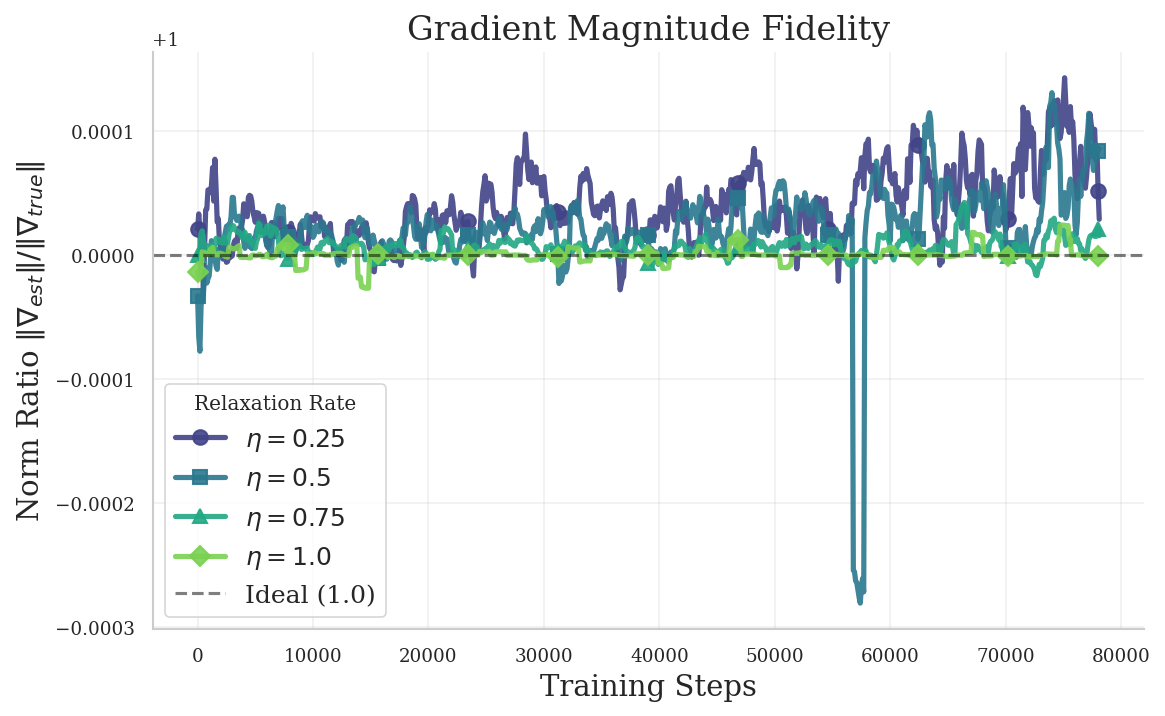

Plotting Cosine Misalignment (Log Scale)...


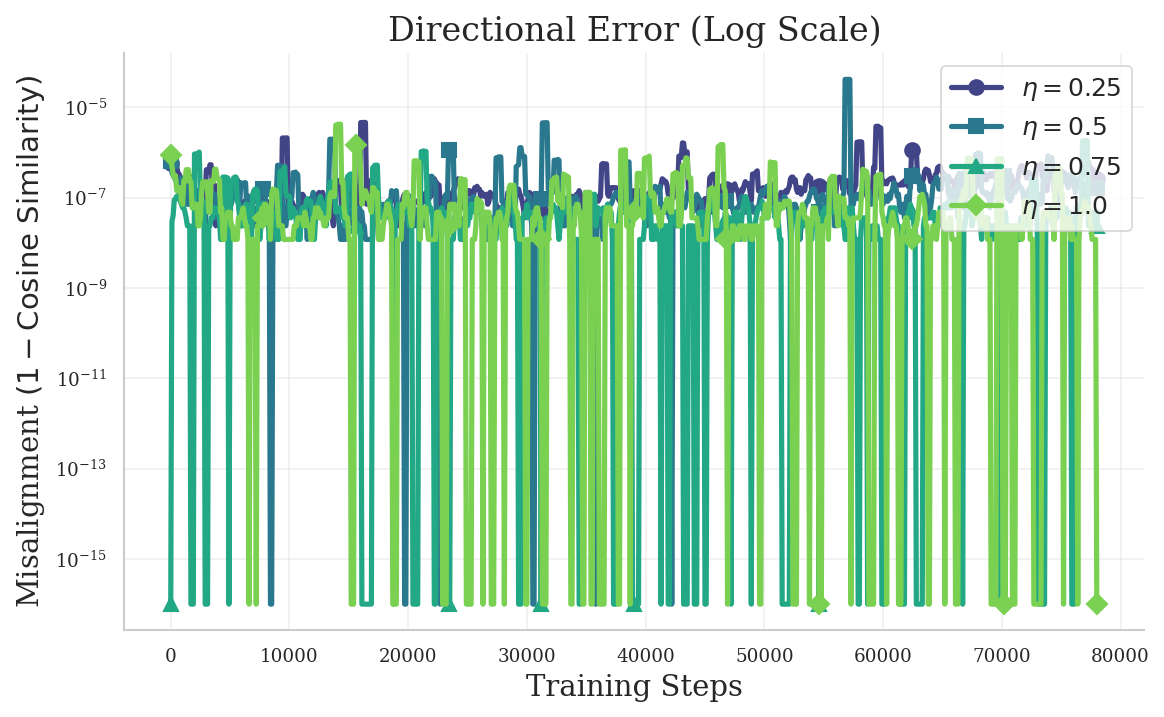

Plotting Layer-wise Heatmap for eta=1.0...


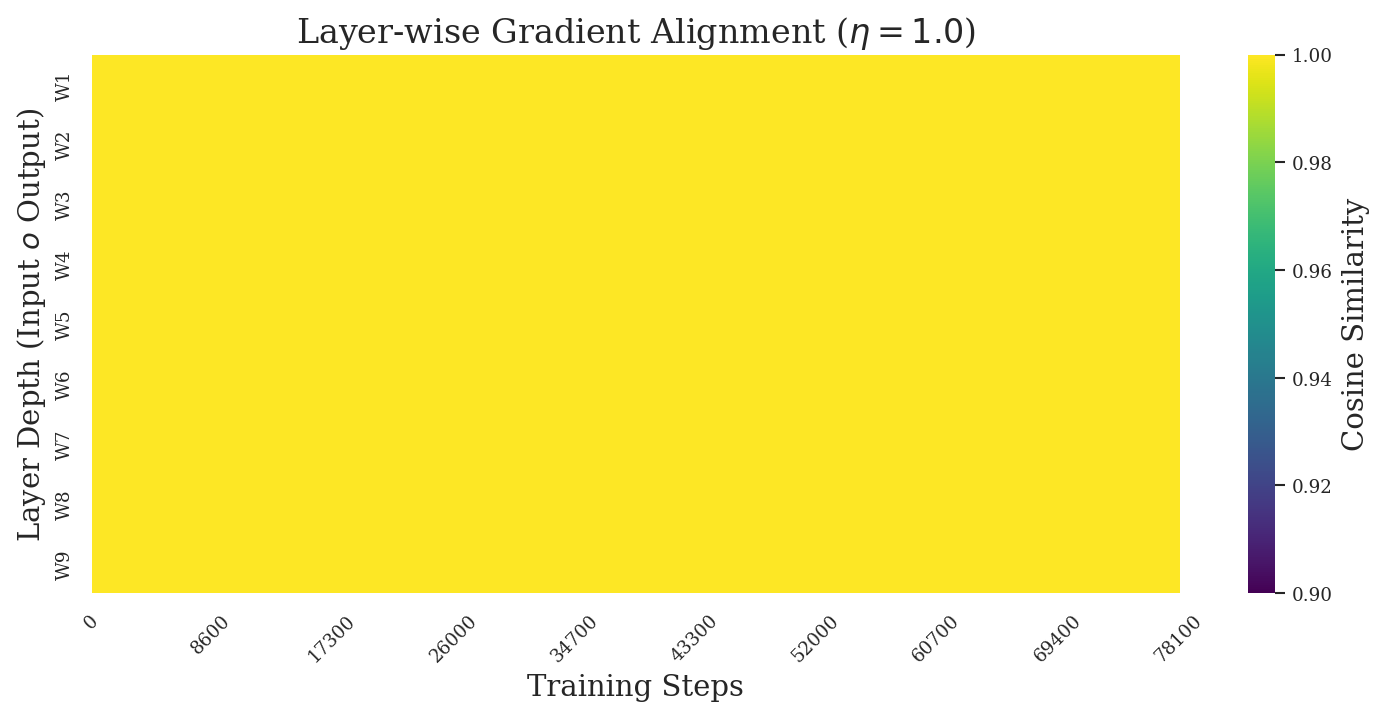

Plotting Gradient SNR...


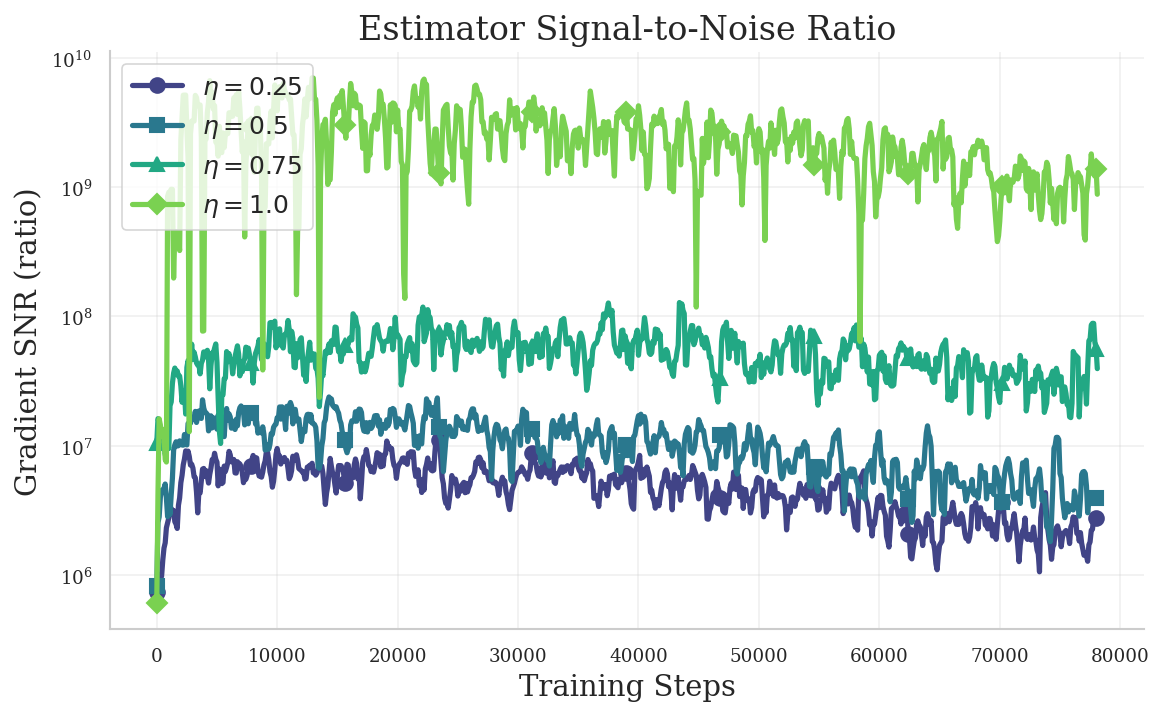

Plotting Bias/Variance for eta=1.0...


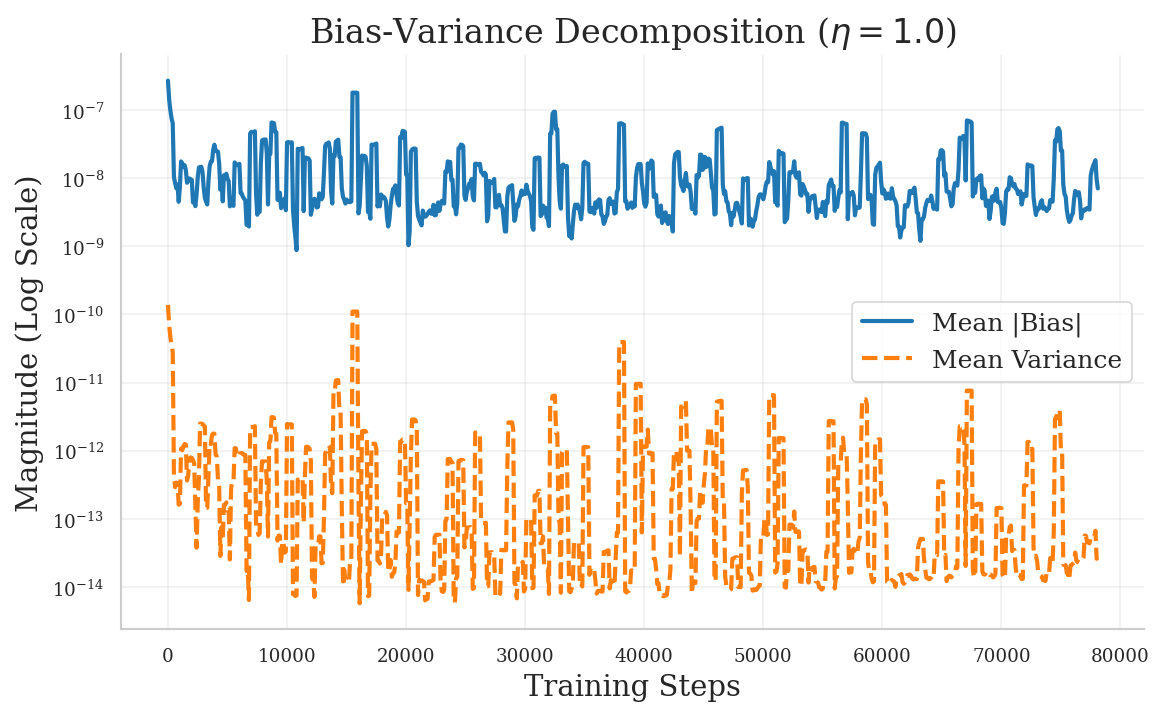

Plotting Relative Error...


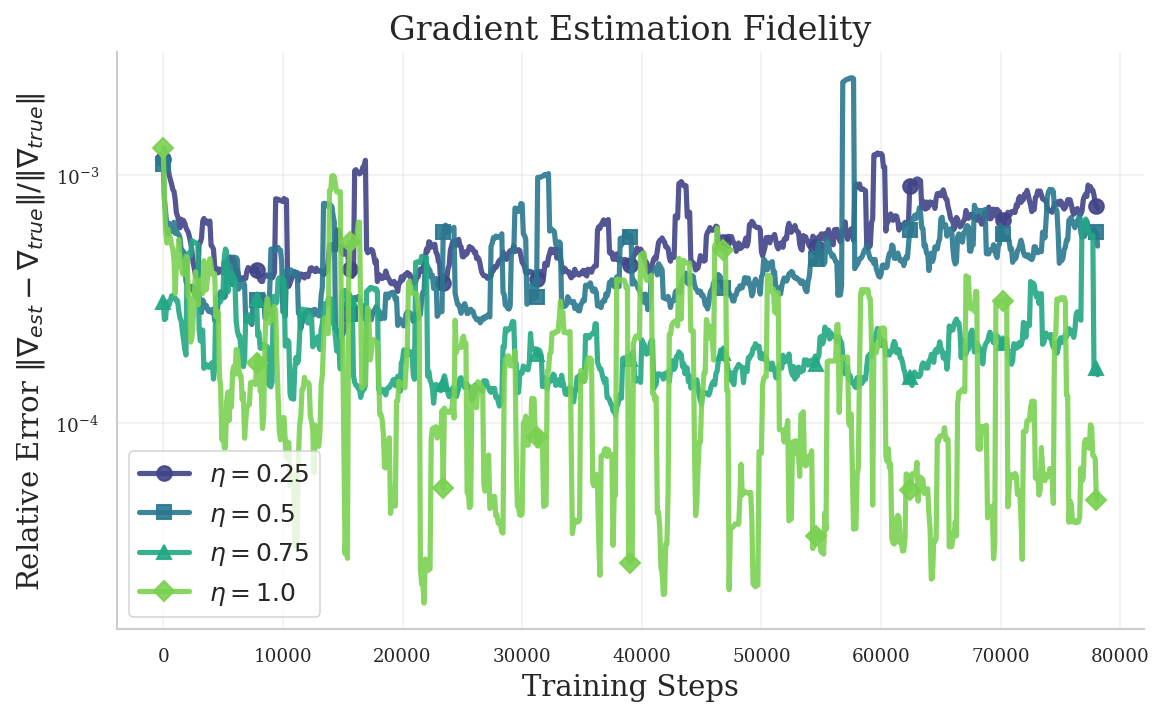

Plotting Accuracy...


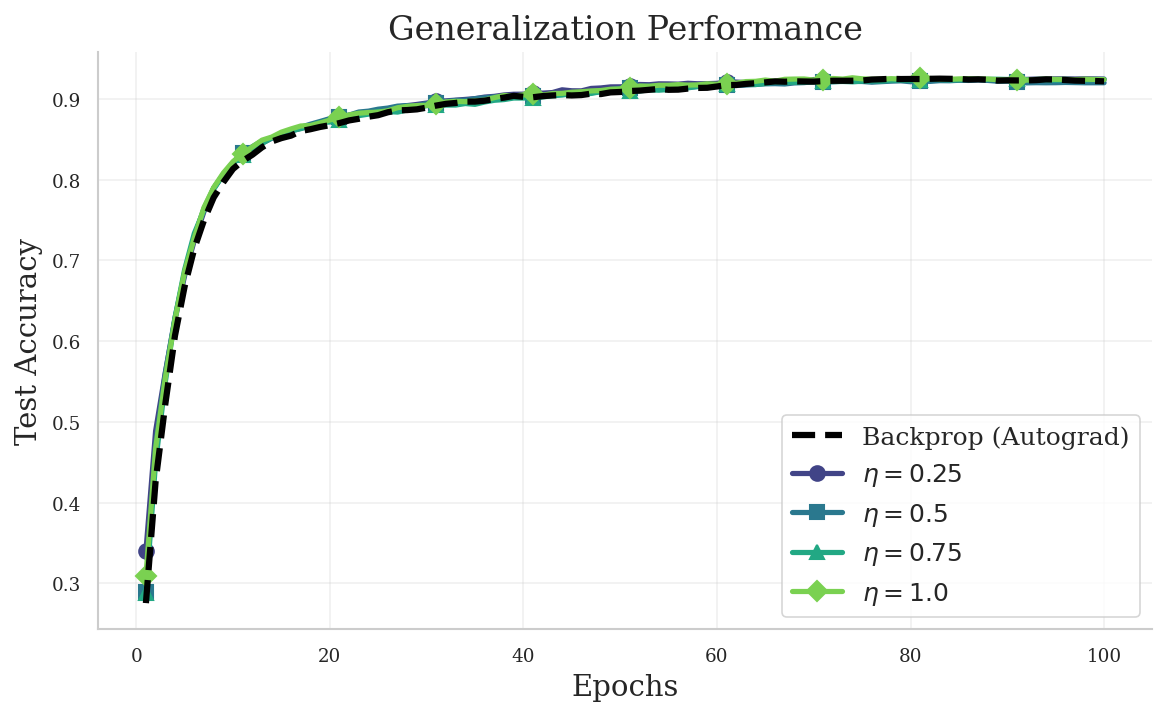

Plotting Convergence...


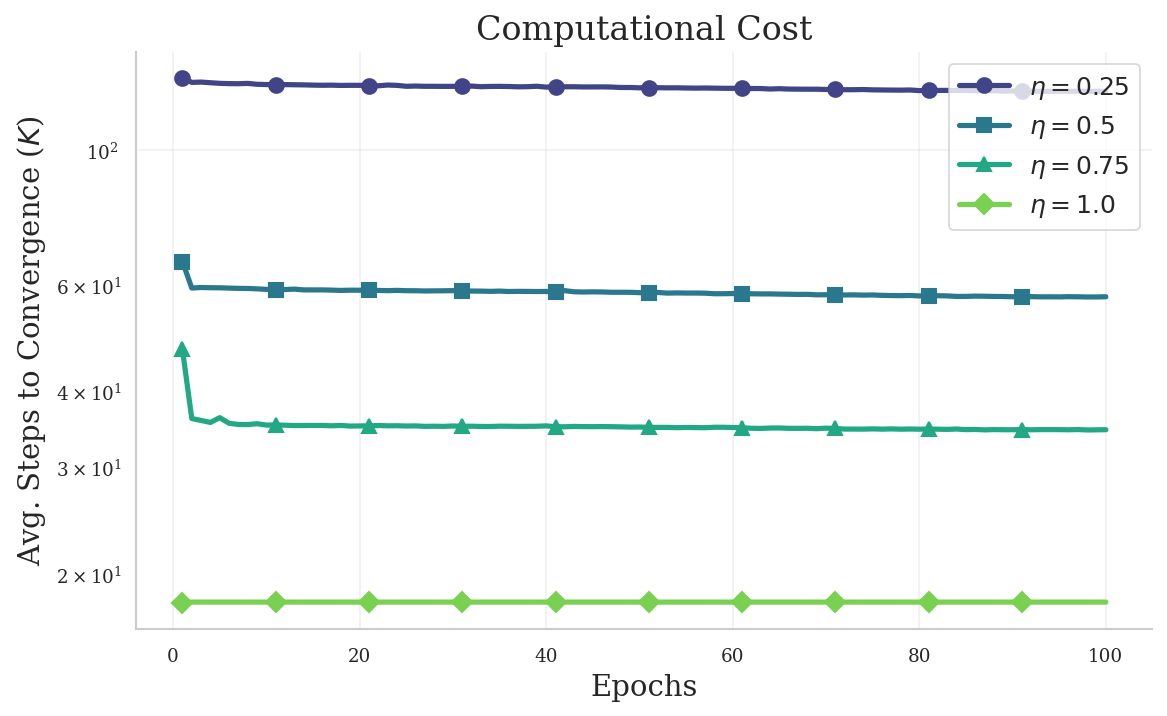


All plots generated successfully.


In [9]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
import os
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# -----------------------------
# 1. ICML STYLE CONFIGURATION
# -----------------------------
def set_icml_style():
    """Sets the plotting style to match ICML/NeurIPS conference standards."""
    plt.rcParams.update(plt.rcParamsDefault)
    sns.set_context("paper")
    sns.set_style("whitegrid")
    
    mpl.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
        "font.size": 14,
        "axes.labelsize": 14,
        "axes.titlesize": 16,
        "legend.fontsize": 12,
        "lines.linewidth": 2.5,
        "lines.markersize": 7,
        "axes.grid": True,
        "grid.alpha": 0.3,
        "figure.figsize": (8, 5),
        "figure.dpi": 150,
        "axes.spines.top": False,
        "axes.spines.right": False,
    })

# -----------------------------
# 2. DATA LOADING
# -----------------------------
def load_data(pt_file, csv_file):
    print(f"Loading {pt_file}...")
    try:
        relax_data = torch.load(pt_file, map_location='cpu')
    except FileNotFoundError:
        print(f"Error: Could not find {pt_file}")
        return None, None

    bp_data = None
    if os.path.exists(csv_file):
        try:
            bp_df = pd.read_csv(csv_file)
            bp_df.columns = [c.lower().strip() for c in bp_df.columns]
            acc_col = next((c for c in bp_df.columns if 'acc' in c), None)
            epoch_col = next((c for c in bp_df.columns if 'ep' in c), None)
            if acc_col:
                bp_acc = bp_df[acc_col].values
                bp_ep = bp_df[epoch_col].values if epoch_col else np.arange(1, len(bp_acc)+1)
                bp_data = {'epoch': bp_ep, 'acc': bp_acc}
        except:
            pass
    return relax_data, bp_data

# -----------------------------
# 3. HELPER FUNCTIONS
# -----------------------------
def get_style(index, total):
    """Returns a unique (color, marker) tuple for consistency."""
    colors = sns.color_palette("viridis", total)
    # Markers: Circle, Square, Triangle, Diamond, Inverted Triangle, X
    markers = ['o', 's', '^', 'D', 'v', 'X'] 
    
    c = colors[index]
    m = markers[index % len(markers)]
    return c, m

def smooth_data(data, window=10):
    """Smooths noisy data using a rolling window."""
    if len(data) > 50:
        return pd.Series(data).rolling(window=window, min_periods=1).mean()
    return data

# -----------------------------
# 4. PLOTTING FUNCTIONS
# -----------------------------

def plot_norm_ratio(relax_data):
    """
    Plots the ratio ||Grad_Est|| / ||Grad_True||. Target is 1.0.
    """
    print("Plotting Norm Ratio...")
    plt.figure()
    
    sorted_items = sorted(relax_data.items())
    total = len(sorted_items)

    for i, (eta, data) in enumerate(sorted_items):
        if 'norm_ratio_hist' not in data: continue
        
        steps = data['cos_steps']
        # Smooth heavily for norm ratio as it can be volatile
        ratios = smooth_data(data['norm_ratio_hist'], window=10)
        
        c, m = get_style(i, total)
        
        plt.plot(steps, ratios, 
                 label=rf'$\eta={eta}$', 
                 color=c, 
                 marker=m,
                 markevery=len(steps)//10,
                 linestyle='-', 
                 alpha=0.9)

    plt.axhline(1.0, color='black', linestyle='--', linewidth=1.5, alpha=0.5, label='Ideal (1.0)')
    
    plt.xlabel("Training Steps")
    plt.ylabel(r"Norm Ratio $\|\nabla_{est}\| / \|\nabla_{true}\|$")
    plt.title("Gradient Magnitude Fidelity")
    plt.legend(title="Relaxation Rate")
    plt.tight_layout()
    plt.show()

def plot_cosine_log_misalignment(relax_data):
    """
    Plots Misalignment (1 - Cosine Similarity) on a log scale.
    This effectively shows Cosine Similarity performance in high definition.
    """
    print("Plotting Cosine Misalignment (Log Scale)...")
    plt.figure()
    
    sorted_items = sorted(relax_data.items())
    total = len(sorted_items)
    
    for i, (eta, data) in enumerate(sorted_items):
        steps = data['cos_steps']
        cos_sim = np.array(data['cos_globalW_hist'])
        
        # Calculate Misalignment
        misalignment = 1.0 - cos_sim
        # Clamp to avoid log(0) issues
        misalignment = np.clip(misalignment, 1e-16, None)
        
        misalignment = smooth_data(misalignment, window=5)
        
        c, m = get_style(i, total)
        
        plt.plot(steps, misalignment, 
                 label=rf'$\eta={eta}$', 
                 color=c, 
                 marker=m,
                 markevery=len(steps)//10,
                 linestyle='-')
    
    plt.yscale('log')
    plt.xlabel("Training Steps")
    plt.ylabel(r"Misalignment $(1 - \text{Cosine Similarity})$")
    plt.title("Directional Error (Log Scale)")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

def plot_layerwise_heatmap(relax_data, eta_to_plot=1.0):
    """
    Plots a heatmap of Cosine Similarity per layer over time for a single eta.
    """
    print(f"Plotting Layer-wise Heatmap for eta={eta_to_plot}...")
    
    if eta_to_plot not in relax_data:
        print(f"Eta {eta_to_plot} not found.")
        return

    data = relax_data[eta_to_plot]
    if 'layer_wise_metrics' not in data:
        print("Layer-wise metrics not found in data.")
        return

    # Extract Data
    history = data['layer_wise_metrics']
    # Names for Y-axis (W1 is input, W9 is output)
    layer_names = [f"W{i}" for i in range(1, 10)]
    
    matrix = []
    steps = []

    for record in history:
        steps.append(record['step'])
        row = []
        for l_data in record['layers']:
            row.append(l_data['cos_sim']) 
        matrix.append(row)

    # Convert to numpy and transpose so Layers are Y-axis
    matrix = np.array(matrix).T 
    
    plt.figure(figsize=(10, 5))
    ax = sns.heatmap(matrix, 
                     yticklabels=layer_names,
                     cmap="viridis", 
                     vmin=0.90, vmax=1.0, # Focus scale on the high-similarity region
                     cbar_kws={'label': 'Cosine Similarity'})
    
    # Format X-axis to show step numbers sparsely
    n_ticks = 10
    step_indices = np.linspace(0, len(steps)-1, n_ticks, dtype=int)
    ax.set_xticks(step_indices)
    ax.set_xticklabels([steps[i] for i in step_indices], rotation=45)
    
    plt.xlabel("Training Steps")
    plt.ylabel("Layer Depth (Input $\to$ Output)")
    plt.title(f"Layer-wise Gradient Alignment ($\eta={eta_to_plot}$)")
    plt.tight_layout()
    plt.show()

def plot_snr_comparison(relax_data):
    """
    Plots the Gradient Signal-to-Noise Ratio (SNR).
    """
    print("Plotting Gradient SNR...")
    plt.figure()
    
    sorted_items = sorted(relax_data.items())
    total = len(sorted_items)

    for i, (eta, data) in enumerate(sorted_items):
        if 'gradient_snr' not in data: continue
        
        steps = data['cos_steps']
        snr = smooth_data(data['gradient_snr'], window=5)

        c, m = get_style(i, total)
        
        plt.plot(steps, snr, 
                 label=rf'$\eta={eta}$', 
                 color=c, 
                 marker=m,
                 markevery=len(steps)//10,
                 linestyle='-')

    plt.yscale('log')
    plt.xlabel("Training Steps")
    plt.ylabel("Gradient SNR (ratio)")
    plt.title("Estimator Signal-to-Noise Ratio")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_bias_variance(relax_data, eta_to_plot=1.0):
    """
    Plots Mean Bias vs Mean Variance for a specific eta to diagnose estimator quality.
    """
    print(f"Plotting Bias/Variance for eta={eta_to_plot}...")
    plt.figure()
    
    if eta_to_plot not in relax_data: return
    data = relax_data[eta_to_plot]
    
    if 'bias_metrics' not in data or 'variance_metrics' not in data: return

    steps = [x['step'] for x in data['bias_metrics']]
    
    # Extract mean bias/var across layers
    bias = np.array([abs(x['mean_bias']) for x in data['bias_metrics']])
    variance = np.array([x['mean_variance'] for x in data['variance_metrics']])
    
    bias = smooth_data(bias, window=5)
    variance = smooth_data(variance, window=5)

    plt.plot(steps, bias, label='Mean |Bias|', color='#1f77b4', linestyle='-', linewidth=2)
    plt.plot(steps, variance, label='Mean Variance', color='#ff7f0e', linestyle='--', linewidth=2)
    
    plt.yscale('log')
    plt.xlabel("Training Steps")
    plt.ylabel("Magnitude (Log Scale)")
    plt.title(f"Bias-Variance Decomposition ($\eta={eta_to_plot}$)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_relative_error_strict(relax_data):
    print("Plotting Relative Error...")
    plt.figure()
    
    sorted_items = sorted(relax_data.items())
    total = len(sorted_items)

    for i, (eta, data) in enumerate(sorted_items):
        steps = data['cos_steps']
        rel_err = smooth_data(data['relerr_globalW_hist'])
        
        c, m = get_style(i, total)
        
        plt.plot(steps, rel_err, 
                 label=rf'$\eta={eta}$', 
                 color=c, 
                 marker=m,
                 markevery=len(steps)//10, 
                 linestyle='-', 
                 alpha=0.9)

    plt.yscale('log')
    plt.xlabel("Training Steps")
    plt.ylabel(r"Relative Error $\|\nabla_{est} - \nabla_{true}\| / \|\nabla_{true}\|$")
    plt.title("Gradient Estimation Fidelity")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_accuracy(relax_data, bp_data):
    print("Plotting Accuracy...")
    plt.figure()
    
    if bp_data:
        plt.plot(bp_data['epoch'], bp_data['acc'], 
                 color='black', linestyle='--', linewidth=3, 
                 label='Backprop (Autograd)', zorder=10)
        
    sorted_items = sorted(relax_data.items())
    total = len(sorted_items)

    for i, (eta, data) in enumerate(sorted_items):
        acc = data['test_acc_hist']
        ep = np.linspace(1, 100, len(acc))
        
        c, m = get_style(i, total)
        
        plt.plot(ep, acc, 
                 label=rf'$\eta={eta}$', 
                 color=c, 
                 marker=m, 
                 markevery=len(ep)//10,
                 linestyle='-')
        
    plt.xlabel("Epochs")
    plt.ylabel("Test Accuracy")
    plt.title("Generalization Performance")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_convergence(relax_data):
    print("Plotting Convergence...")
    plt.figure()
    
    sorted_items = sorted(relax_data.items())
    total = len(sorted_items)
    
    for i, (eta, data) in enumerate(sorted_items):
        k = data['avg_steps_per_epoch']
        ep = range(1, len(k)+1)
        
        c, m = get_style(i, total)
        
        plt.plot(ep, k, 
                 label=rf'$\eta={eta}$', 
                 color=c, 
                 marker=m,
                 markevery=len(ep)//10,
                 linestyle='-')
        
    plt.yscale('log')
    plt.xlabel("Epochs")
    plt.ylabel("Avg. Steps to Convergence ($K$)")
    plt.title("Computational Cost")
    plt.legend()
    plt.tight_layout()
    plt.show()

# -----------------------------
# 5. EXECUTION
# -----------------------------
def main():
    set_icml_style()
    pt_file = "experiment_data_seed11_18convergence.pt"
    csv_file = "training_log.csv"
    
    relax, bp = load_data(pt_file, csv_file)
    
    if relax:
        print("\n--- Generating Plots ---")
        
        # 1. New Requests
        plot_norm_ratio(relax)
        plot_cosine_log_misalignment(relax)
        
        # 2. Rich Data Diagnostics
        # Heatmap for the best performing eta (usually 1.0)
        plot_layerwise_heatmap(relax, eta_to_plot=1.0)
        plot_snr_comparison(relax)
        plot_bias_variance(relax, eta_to_plot=1.0)
        
        # 3. Standard Metrics
        plot_relative_error_strict(relax)
        plot_accuracy(relax, bp)
        plot_convergence(relax)
        
        print("\nAll plots generated successfully.")
    else:
        print("No relaxation data found. Please check file path.")

if __name__ == "__main__":
    main()